# Titanic Survivor Prediction Challenge

👨‍💻 **Arjun Adhikari**, July 30, 2019

Importing the required libraries.

In [1]:
import pandas as pd
import numpy as np

Importing datasets.

In [2]:
train_data=pd.read_csv('Train.csv')
train_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,3,0,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.750,NaN,Q,NaN,NaN,NaN
1,2,0,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.000,NaN,S,NaN,NaN,NaN
2,2,1,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.000,NaN,S,9,NaN,NaN
3,3,1,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.525,NaN,S,C D,NaN,"Strood, Kent, England Detroit, MI"
4,3,1,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.250,NaN,Q,16,NaN,NaN


In [3]:
print(train_data.columns)

Index([u'pclass', u'survived', u'name', u'sex', u'age', u'sibsp', u'parch',
       u'ticket', u'fare', u'cabin', u'embarked', u'boat', u'body',
       u'home.dest'],
      dtype='object')


In [4]:
columns=["name","ticket","embarked","cabin","boat","home.dest"]
data_clean=train_data.drop(columns,axis=1)
print(data_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 8 columns):
pclass      1009 non-null int64
survived    1009 non-null int64
sex         1009 non-null object
age         812 non-null float64
sibsp       1009 non-null int64
parch       1009 non-null int64
fare        1008 non-null float64
body        98 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 63.1+ KB
None


In [5]:
data_clean.head()

,pclass,survived,sex,age,sibsp,parch,fare,body
0,3,0,female,NaN,0,0,7.750,NaN
1,2,0,male,39.0,0,0,26.000,NaN
2,2,1,female,40.0,0,0,13.000,NaN
3,3,1,female,31.0,1,1,20.525,NaN
4,3,1,female,NaN,2,0,23.250,NaN


Importing Label Encoder from Scikit Learn.

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le=LabelEncoder()
data_clean["sex"]=le.fit_transform(data_clean["sex"])
data_clean.head()

,pclass,survived,sex,age,sibsp,parch,fare,body
0,3,0,0,NaN,0,0,7.750,NaN
1,2,0,1,39.0,0,0,26.000,NaN
2,2,1,0,40.0,0,0,13.000,NaN
3,3,1,0,31.0,1,1,20.525,NaN
4,3,1,0,NaN,2,0,23.250,NaN


In [8]:
data_clean=data_clean.fillna(data_clean["age"].mean()) 
data_clean.head()

,pclass,survived,sex,age,sibsp,parch,fare,body
0,3,0,0,29.838978,0,0,7.750,29.838978
1,2,0,1,39.000000,0,0,26.000,29.838978
2,2,1,0,40.000000,0,0,13.000,29.838978
3,3,1,0,31.000000,1,1,20.525,29.838978
4,3,1,0,29.838978,2,0,23.250,29.838978


In [9]:
input_cols=["pclass","sex","age","sibsp","parch","fare","body"]
output_cols=["survived"]
X_train=data_clean[input_cols]
Y_train=data_clean[output_cols]
print(X_train.shape,Y_train.shape)

((1009, 7), (1009, 1))


In [10]:
print(data_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 8 columns):
pclass      1009 non-null int64
survived    1009 non-null int64
sex         1009 non-null int64
age         1009 non-null float64
sibsp       1009 non-null int64
parch       1009 non-null int64
fare        1009 non-null float64
body        1009 non-null float64
dtypes: float64(3), int64(5)
memory usage: 63.1 KB
None


## Algorithms

### Entropy Calculation

In [11]:
def entropy(col):
    
    n=col.shape[0]
    ent=0.0
    count=np.unique(col,return_counts=True)
    
    for ix in count[1]:
        
        p=ix/n
        ent+=(-1.0*p*np.log2(p))
        
    return ent

### Data Division

In [12]:
def divide_data(x_data,fkey,fval):
    
    left=pd.DataFrame([],columns=x_data.columns)
    right=pd.DataFrame([],columns=x_data.columns)
    
    for ix in range(x_data.shape[0]):
        
        val=x_data[fkey].loc[ix]
        if val>fval:
            left=left.append(x_data.loc[ix])
        else:
            right=right.append(x_data.loc[ix])
            
    return left,right

### Information Gain

In [13]:
def information_gain(x_data,fkey,fval):
    
    left,right=divide_data(x_data,fkey,fval)
    l=float(left.shape[0]/x_data.shape[0])
    r=float(right.shape[0]/x_data.shape[0])
    
    if left.shape[0]==0 or right.shape[0]==0:
        return -100000000
    
    i_gain=entropy(x_data.survived)-(l*entropy(left.survived)+r*entropy(right.survived))
    
    return i_gain

#### Class for training and prediction

In [14]:
class DecisionTree:
    
    def __init__(self,depth=0,max_depth=5):
        
        self.left=None
        self.right=None
        self.fkey=None
        self.fval=None
        self.depth=depth
        self.max_depth=max_depth
        self.target=None
        
    def train(self,X_train):
        
        features=["pclass","sex","age","sibsp","parch","fare","body"]
        information=[]
        
        for ix in features:
            ig=information_gain(X_train,ix,X_train[ix].mean())
            information.append(ig)
            
        self.fkey=features[np.argmax(information)]
        self.fval=X_train[self.fkey].mean()
        left,right=divide_data(X_train,self.fkey,self.fval)
        left=left.reset_index(drop=True)
        right=right.reset_index(drop=True)
        
        if left.shape[0]==0 or right.shape[0]==0:
            if X_train.survived.mean()>=0.5:
                self.target="survived"
            else:
                self.target="dead"
            return
        if self.depth>=self.max_depth:
            if X_train.survived.mean()>=0.5:
                self.target="survived"
            else:
                self.target="dead"
            return
        self.left=DecisionTree(self.depth+1,self.max_depth)
        self.left.train(left)
        self.right=DecisionTree(self.depth+1,self.max_depth)
        self.right.train(right)
        if X_train.survived.mean()>=0.5:
            self.target="survived"
        else:
            self.target="dead"
        return 
    
    def predict(self,test):
        
        if test[self.fkey]>self.fval:
            if self.right is None:
                return self.target
            return self.right.predict(test)
        else:
            if self.left is None:
                return self.target
            return self.left.predict(test)

In [15]:
dt=DecisionTree()
dt.train(data_clean)

/home/arjun/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.
/home/arjun/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [16]:
test_data=pd.read_csv('Test.csv')
test_data.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Flynn, Mr. John Irwin (""Irving"")",male,36.0,0,0,PC 17474,26.3875,E25,S,5,NaN,"Brooklyn, NY"
1,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S,NaN,NaN,NaN
2,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,A32,S,NaN,NaN,"Seattle, WA"
3,2,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,NaN,NaN,"Vancouver, BC"
4,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S,NaN,NaN,"Helsinki, Finland Ashtabula, Ohio"


In [17]:
print(dt.fkey)
print(dt.fval)
print(dt.left.fkey)
print(dt.right.fkey)

pclass
2.2953419226957386
sex
pclass


In [18]:
columns=["name","ticket","embarked","cabin","boat","home.dest"]
test_data_clean=test_data.drop(columns,axis=1)
print(test_data_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
pclass    300 non-null int64
sex       300 non-null object
age       234 non-null float64
sibsp     300 non-null int64
parch     300 non-null int64
fare      300 non-null float64
body      23 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 16.5+ KB
None


Importing LabelEncoder from ```Scikit-Learn```.

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
le=LabelEncoder()
test_data_clean["sex"]=le.fit_transform(test_data_clean["sex"])
print(test_data_clean.head())

   pclass  sex   age  sibsp  parch     fare  body
0       1    1  36.0      0      0  26.3875   NaN
1       3    0   NaN      8      2  69.5500   NaN
2       1    1   NaN      0      0  50.0000   NaN
3       2    1  34.0      0      0  13.0000   NaN
4       2    1  28.0      0      0  13.0000   NaN


In [21]:
test_data_clean=test_data_clean.fillna(test_data_clean["age"].mean()) 
print(test_data_clean.head()) # kisi ek particular column k nan ko modify krna h to kya kru

   pclass  sex        age  sibsp  parch     fare       body
0       1    1  36.000000      0      0  26.3875  30.027422
1       3    0  30.027422      8      2  69.5500  30.027422
2       1    1  30.027422      0      0  50.0000  30.027422
3       2    1  34.000000      0      0  13.0000  30.027422
4       2    1  28.000000      0      0  13.0000  30.027422


In [22]:
test_data_clean=test_data_clean.reset_index(drop=True)
pred=[]
for ix in range(test_data_clean.shape[0]):
    pred.append(dt.predict(test_data_clean.loc[ix]))

In [23]:
pred=le.fit_transform(pred)
print(pred)

[1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1
 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1
 0 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0
 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1
 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0
 0 1 1 0]


In [24]:
print(len(pred))

300


In [25]:
print(test_data_clean.shape[0])

300


In [26]:
Id=np.arange(test_data_clean.shape[0])
print(Id)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [27]:
result=np.stack((Id,pred),axis=1)

In [28]:
result_df=pd.DataFrame(result,columns=["Id","survived"])

In [29]:
print(result_df.head())

   Id  survived
0   0         1
1   1         0
2   2         1
3   3         1
4   4         1


In [30]:
result_df.to_csv("resultss.csv",index=False)

Exporting results to ```results.csv```.

Importing DecisionTreeClassifier from ```scikit-learn```.

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
dt=DecisionTreeClassifier(criterion="entropy",max_depth=5)

In [33]:
dt.fit(data_clean[input_cols],data_clean[output_cols])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [34]:
pred=dt.predict(test_data_clean[input_cols])

### Accuracy Improvement

In [35]:
import warnings 

In [36]:
warnings.filterwarnings("ignore")

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf=RandomForestClassifier(n_estimators=45,criterion="entropy",max_depth=5)

In [39]:
rf.fit(data_clean[input_cols],data_clean[output_cols])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
pred=rf.predict(test_data_clean[input_cols])

In [41]:
from sklearn.model_selection import cross_val_score
acc=cross_val_score(RandomForestClassifier(n_estimators=10,criterion='entropy',max_depth=10),data_clean[input_cols],data_clean[output_cols],cv=5).mean()

In [42]:
print(acc)

0.805778986839203


In [43]:
acc_list=[]

for i in range(1,50):
    
    acc=cross_val_score(RandomForestClassifier(n_estimators=i,criterion='entropy',max_depth=10),data_clean[input_cols],data_clean[output_cols],cv=5).mean()
    acc_list.append(acc)

In [44]:
import matplotlib.pyplot as plt

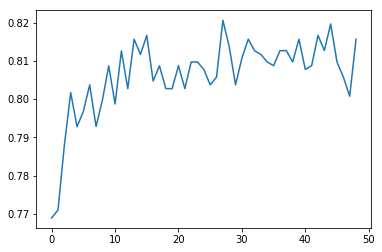

In [45]:
plt.plot(acc_list)
plt.show()

In [46]:
print(np.argmax(acc_list))

27
